In [1]:
from datetime import datetime
from pathlib import Path
import glob
import os
import geoutils as gu
import xdem
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import pandas as pd
import altair as alt
from pprint import pprint
from rasterio.enums import Resampling
import copy
import json 

# Inputs

* Inputs are written in a JSON.
* The inputs file is specified by the `HSFM_GEOMORPH_INPUT_FILE` env var
* One input may be overriden with an additional env var - `RUN_LARGER_AREA`. If this env var is set to "yes" or "no" (exactly that string, it will be used. If the env var is not set, the params file is used to fill in this variable. If some other string is set, a failure is thrown).

If you use the arg, you must run from CLI like this

```
HSFM_GEOMORPH_INPUT_FILE='inputs/mazama_inputs.json' jupyter nbconvert --execute --to html dem-analysis/mt_baker_mass_wasted/xdem.ipynb  --output outputs/xdem_mazama.html
```

In [2]:
if os.environ.get('HSFM_GEOMORPH_INPUT_FILE'):
    json_file_path = os.environ['HSFM_GEOMORPH_INPUT_FILE']
else:
    json_file_path = 'inputs/rainbow_inputs.json'

In [3]:
with open(json_file_path, 'r') as j:
     params = json.loads(j.read())

In [4]:
params

{'inputs': {'valley_name': 'Rainbow',
  'TO_DROP': ['1970_09_09',
   '1979_10_06',
   '1987_08_21',
   '1992_09_15',
   '1992_09_18',
   '2013_09_13',
   '2019_10_11'],
  'TO_DROP_LARGER_AREA': ['1970_09_09',
   '1970_09_29',
   '1974_08_10',
   '1979_10_06',
   '1987_08_21',
   '1991_09_09',
   '1992_09_15',
   '1992_09_18',
   '2013_09_13',
   '2019_10_11'],
  'XSECTIONS_INCLUDE': None,
  'erosion_polygon_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/erosion.geojson',
  'erosion_by_date_polygon_file': None,
  'glacier_polygons_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/glaciers.geojson',
  'dems_path': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems',
  'valley_bounds_file': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/valley_bounds.geojson',
  'plot_output_dir': '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/plots/',
  'uncertainty_file': 'outputs/uncertainty_rainbow.pc

In [5]:
VALLEY_BOUNDS_NAME = params["inputs"]["valley_name"]
dems_path = params["inputs"]["dems_path"]
gcas_polygon_file = params["uncertainty"]["gcas_polygon_file"]
valley_bounds_file = params["inputs"]["valley_bounds_file"]
plot_output_dir = params["inputs"]["plot_output_dir"]
output_file = params["inputs"]["uncertainty_file"]
output_file_largerarea = params["inputs"]["uncertainty_file_largearea"]
TO_DROP = params["inputs"]["TO_DROP"]
TO_DROP_LARGERAREA = params["inputs"]["TO_DROP_LARGER_AREA"]
TO_COREGISTER = params["inputs"]["TO_COREGISTER"]
DATE_FILE_FORMAT = params['inputs']['strip_time_format']
FILTER_OUTLIERS = params['inputs']['FILTER_OUTLIERS']
SIMPLE_FILTER = params['inputs']['SIMPLE_FILTER']
simple_filter_threshold = params['inputs']['simple_filter_threshold']

reference_dem_date = datetime.strptime(
    params['inputs']['reference_dem_date'], 
    DATE_FILE_FORMAT
)

if os.environ.get('RUN_LARGER_AREA'):
    print("RUN_LARGER_AREA env var read.")
    if os.environ['RUN_LARGER_AREA'] == "yes":
        print("Running larger area")
        RUN_LARGER_AREA = True
    elif os.environ['RUN_LARGER_AREA'] == "no":
        print("NOT running larger area")
        RUN_LARGER_AREA = False
    else:
        raise ValueError("Env Var RUN_LARGER_AREA set to an incorrect value. Cannot proceed.")
else:
    RUN_LARGER_AREA = params['inputs']['RUN_LARGER_AREA']

VARIOGRAM_SUBSAMPLE = params["uncertainty"]["VARIOGRAM_SUBSAMPLE"]
VARIOGRAM_N_VARIOGRAMS = params["uncertainty"]["VARIOGRAM_N_VARIOGRAMS"]
PARALLELISM = params["uncertainty"]["PARALLELISM"]
XSCALE_RANGE_SPLIT = params["uncertainty"]["XSCALE_RANGE_SPLIT"]
MAX_LAG = params["uncertainty"]["MAX_LAG"]
RESAMPLING_RES = params["uncertainty"]["RESAMPLING_RES"]

In [6]:
VARIOGRAM_SUBSAMPLE, \
VARIOGRAM_N_VARIOGRAMS, \
PARALLELISM, \
XSCALE_RANGE_SPLIT, \
MAX_LAG, \
RESAMPLING_RES

(10000, 10, 64, [200], 1000, 2)

In [8]:
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir, exist_ok=True)

# Get DEM file paths

In [9]:
dem_fn_list = glob.glob(os.path.join(dems_path, "*.tif"))
dem_fn_list = sorted(dem_fn_list)

if RUN_LARGER_AREA:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP_LARGERAREA]
else:
    dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/1947_09_14.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/1977_09_27.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/2015_09_01.tif']

In [10]:
dem_fn_list = [f for f in dem_fn_list if 'unaligned' not in f]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/1947_09_14.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/1977_09_27.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/2015_09_01.tif']

In [11]:
datetimes = [datetime.strptime(Path(f).stem, DATE_FILE_FORMAT) for f in dem_fn_list]
datetimes

[datetime.datetime(1947, 9, 14, 0, 0),
 datetime.datetime(1977, 9, 27, 0, 0),
 datetime.datetime(2015, 9, 1, 0, 0)]

# Open Valley Bounds Geometry

In [12]:
valley_bounds = gu.Vector(valley_bounds_file)
uncertainty_valley_bounds_vect = valley_bounds.query(f"name == '{VALLEY_BOUNDS_NAME}' and purpose=='uncertainty'")
uncertainty_valley_bounds_vect.ds

,id,name,purpose,geometry
2,None,Rainbow,uncertainty,"POLYGON ((593228.034 5403662.849, 593191.854 5..."


# Create DEMCollection

In [13]:
demcollection_uncertainty = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    uncertainty_valley_bounds_vect, 
    RESAMPLING_RES,
    Resampling.cubic
)

In [14]:
if TO_COREGISTER:
    for i in range(0, len(demcollection_uncertainty.dems)-1):
        early_dem = demcollection_uncertainty.dems[i]
        late_dem = demcollection_uncertainty.dems[i+1]

        nuth_kaab = xdem.coreg.NuthKaab()
        # Order with the future as reference
        nuth_kaab.fit(late_dem.data, early_dem.data, transform=late_dem.transform)

        # Apply the transformation to the data (or any other data)
        aligned_ex = nuth_kaab.apply(early_dem.data, transform=early_dem.transform)

        print(F"For DEM {early_dem.datetime}, transform is {nuth_kaab.to_matrix()}")

        early_dem.data = np.expand_dims(aligned_ex, axis=0)

In [15]:
_ = demcollection_uncertainty.subtract_dems_intervalwise()

# Create Bounding DEMCollection

In [16]:
bounding_demcollection_uncertainty = xdem.DEMCollection(
    [demcollection_uncertainty.dems[0], demcollection_uncertainty.dems[-1]],
    [demcollection_uncertainty.timestamps[0], demcollection_uncertainty.timestamps[-1]],
)

_ = bounding_demcollection_uncertainty.subtract_dems_intervalwise()

# Plot dDEMs

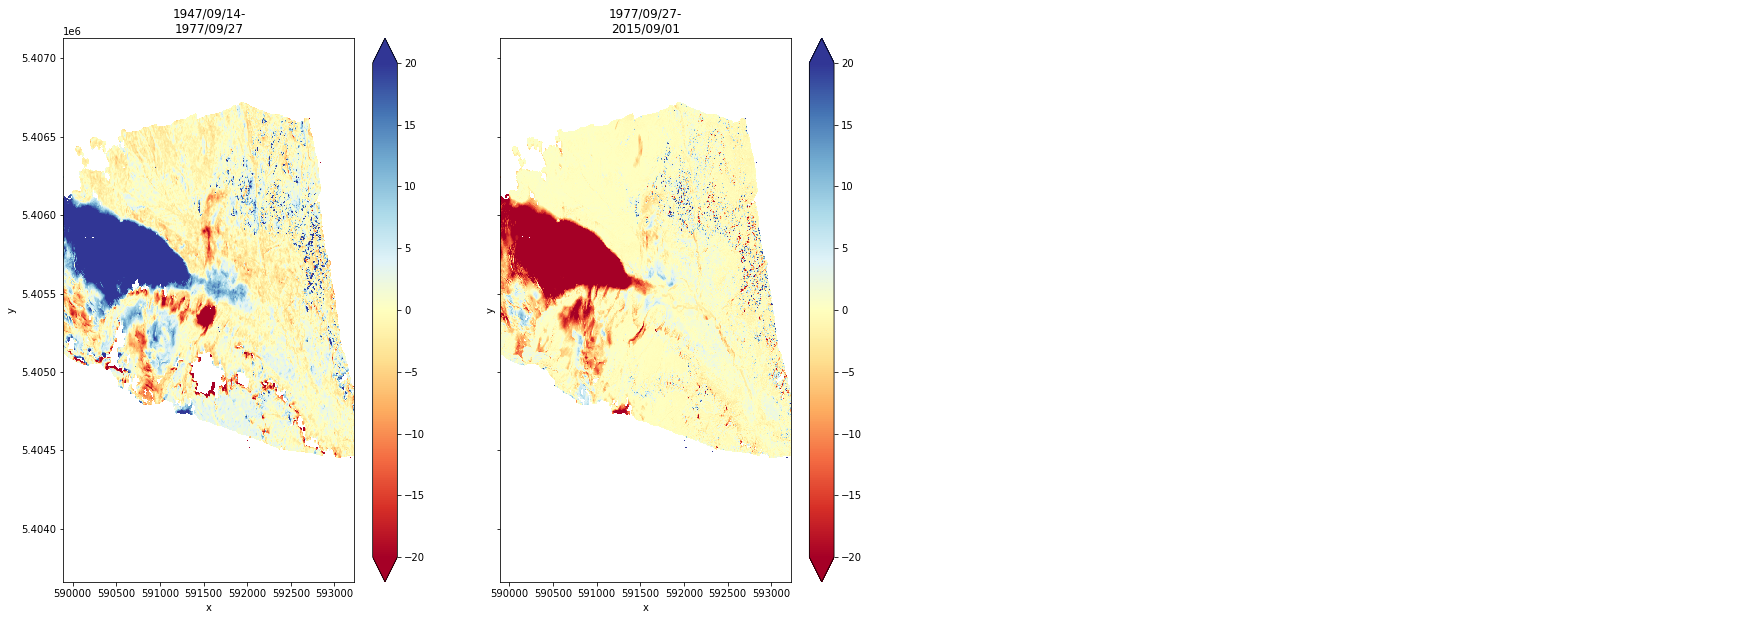

In [17]:
fig, axes = demcollection_uncertainty.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")
fig.savefig(os.path.join(plot_output_dir, "dod_gallery.png"))
plt.show()

# Plot Bounding dDEMs

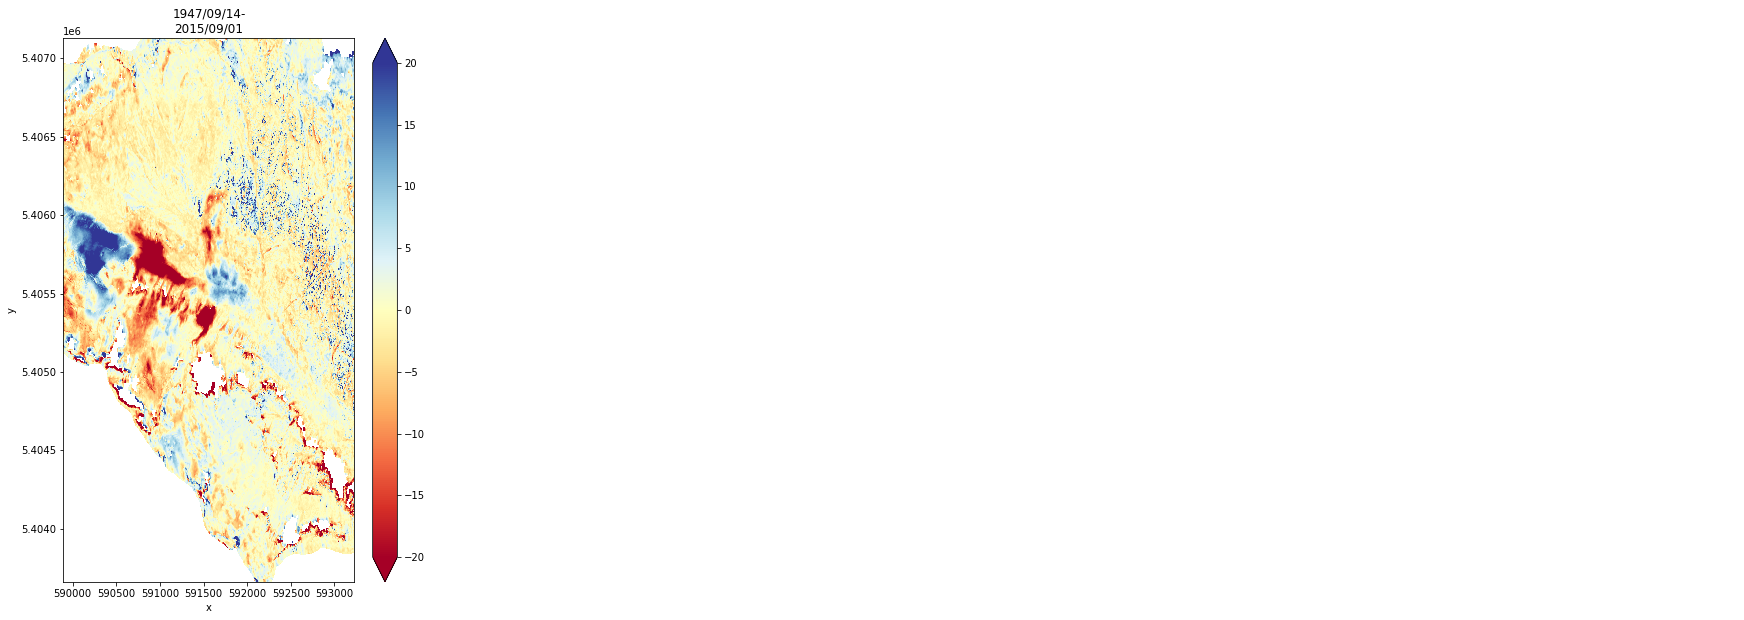

In [18]:
fig, axes = bounding_demcollection_uncertainty.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, interpolation = "none")
fig.savefig(os.path.join(plot_output_dir, "bounding_dod_gallery.png"))
plt.show()

# Calculate Uncertainty

## Open ground control polygons

In [19]:
gcas_vector = gu.Vector(gcas_polygon_file)

## Define function to perform an uncertainty analysis:
* Plot ground control area DH
* Sample dataset and plot empirical variogram
* Fit spherical model and plot empirical variogram + fitted model
* Print comprehensive statistics

In [20]:
from uncertainty_helpers import uncertainty_analysis

In [21]:
# Collect the results as we create them
results_dict = {}

In [22]:
def clean_interval_string(interval):
    return interval.left.strftime("%y_%m_%d") + "__" + interval.right.strftime("%y_%m_%d")

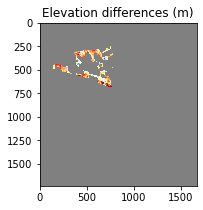

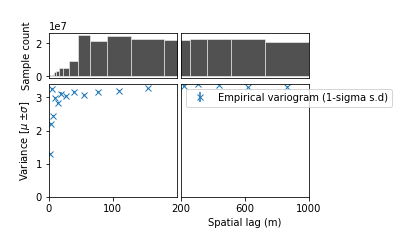

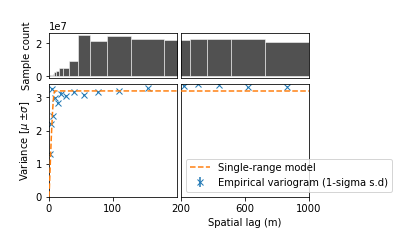

{'Count of all pixels': 1256366,
 'Count of stable pixels': 135143,
 'Interval': Interval('1947-09-14', '1977-09-27', closed='right'),
 'Max': 21.5491943359375,
 'Mean': -0.7529027462005615,
 'Median': -0.7684326171875,
 'Min': -34.0279541015625,
 'NMAD': 1.71642802734375,
 'Outlier lower limit': -50,
 'Outlier upper limit': 50,
 'Percentage all pixels filtered/removed': 0.045116502131521206,
 'Percentage stable pixels filtered/removed': 0.0,
 'RMSE': 2.0319927116077663,
 'Range': 8.959726598363298,
 'Sill': 3.196749214367564,
 'StdDev': 1.8873610496520996,
 'pre-filter': {'Count of all pixels': 1315727,
                'Count of stable pixels': 135143,
                'Max': 21.5491943359375,
                'Mean': -0.7529027462005615,
                'Median': -0.7684326171875,
                'Min': -34.0279541015625,
                'NMAD': 1.71642802734375,
                'RMSE': 2.0319927116077663,
                'StdDev': 1.8873610496520996}}


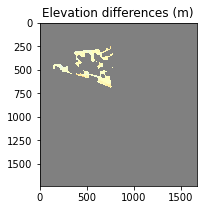

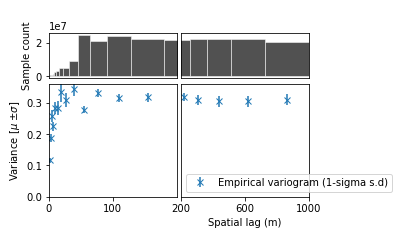

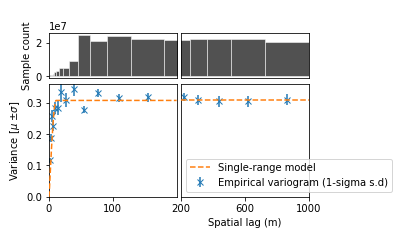

{'Count of all pixels': 1314477,
 'Count of stable pixels': 135228,
 'Interval': Interval('1977-09-27', '2015-09-01', closed='right'),
 'Max': 14.3426513671875,
 'Mean': 0.006924191024154425,
 'Median': 0.052001953125,
 'Min': -21.5362548828125,
 'NMAD': 0.2763586669921875,
 'Outlier lower limit': -50,
 'Outlier upper limit': 50,
 'Percentage all pixels filtered/removed': 0.038122340978241936,
 'Percentage stable pixels filtered/removed': 0.0,
 'RMSE': 0.5607787412499697,
 'Range': 10.982636479206526,
 'Sill': 0.3070019918003497,
 'StdDev': 0.5607361197471619,
 'pre-filter': {'Count of all pixels': 1366574,
                'Count of stable pixels': 135228,
                'Max': 14.3426513671875,
                'Mean': 0.006924191024154425,
                'Median': 0.052001953125,
                'Min': -21.5362548828125,
                'NMAD': 0.2763586669921875,
                'RMSE': 0.5607787412499697,
                'StdDev': 0.5607361197471619}}


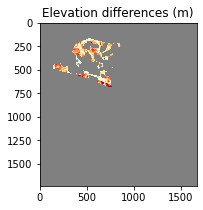

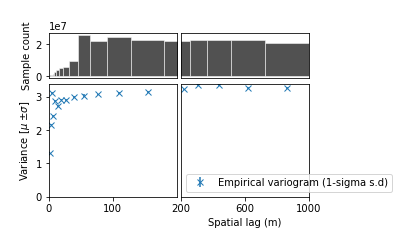

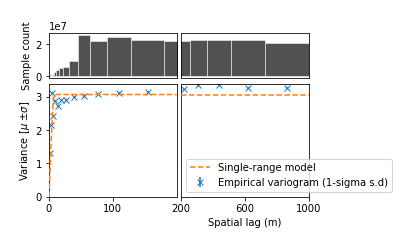

{'Count of all pixels': 2271006,
 'Count of stable pixels': 172384,
 'Interval': Interval('1947-09-14', '2015-09-01', closed='right'),
 'Max': 21.760009765625,
 'Mean': -0.7842625379562378,
 'Median': -0.8046875,
 'Min': -34.0924072265625,
 'NMAD': 1.6930814208984375,
 'Outlier lower limit': -50,
 'Outlier upper limit': 50,
 'Percentage all pixels filtered/removed': 0.0007233845950762326,
 'Percentage stable pixels filtered/removed': 0.0,
 'RMSE': 2.02120249055926,
 'Range': 8.693137218337439,
 'Sill': 3.0666001407247006,
 'StdDev': 1.8628449440002441,
 'pre-filter': {'Count of all pixels': 2272650,
                'Count of stable pixels': 172384,
                'Max': 21.760009765625,
                'Mean': -0.7842625379562378,
                'Median': -0.8046875,
                'Min': -34.0924072265625,
                'NMAD': 1.6930814208984375,
                'RMSE': 2.02120249055926,
                'StdDev': 1.8628449440002441}}


In [23]:
def run_analysis_plot_and_return_results(ddem):
    results, figs = uncertainty_analysis(
        ddem,
        gcas_vector,
        subsample = VARIOGRAM_SUBSAMPLE,
        n_variograms = VARIOGRAM_N_VARIOGRAMS,
        xscale_range_split = XSCALE_RANGE_SPLIT,
        parallelism=PARALLELISM,
        maxlag=MAX_LAG,
        FILTER_OUTLIERS = FILTER_OUTLIERS,
        SIMPLE_FILTER = SIMPLE_FILTER,
        simple_filter_threshold = simple_filter_threshold
    )
    interval_string = clean_interval_string(ddem.interval)
    figs[0].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_static_areas_{interval_string}.png"))
    figs[1].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_empirical_variogram_{interval_string}.png"))
    figs[2].savefig(os.path.join(plot_output_dir, f"dod_uncertainty_fit_variogram_{interval_string}.png"))
    pprint(results, width=1)
    return results
    

for ddem in demcollection_uncertainty.ddems:
    results = run_analysis_plot_and_return_results(ddem)
    results['bounding'] = False
    results_dict[results["Interval"]] = results

for ddem in bounding_demcollection_uncertainty.ddems:
    results = run_analysis_plot_and_return_results(ddem)
    results['bounding'] = True
    results_dict[results["Interval"]] = results

### Analyze all uncertainty results

In [24]:
from scipy import stats

In [25]:
results_df = pd.DataFrame(results_dict).transpose().reset_index(drop=True)
results_df['Start Date'] = results_df['Interval'].apply(lambda x: x.left)
results_df['End Date'] = results_df['Interval'].apply(lambda x: x.right)
results_df['NMAD'] = pd.to_numeric(results_df['NMAD'])
results_df['Mean'] = pd.to_numeric(results_df['Mean'])
results_df['RMSE'] = pd.to_numeric(results_df['RMSE'])
results_df['Range'] = pd.to_numeric(results_df['Range'])
results_df['Sill'] = pd.to_numeric(results_df['Sill'])
results_df['StdDev'] = pd.to_numeric(results_df['StdDev'])
results_df['90% CI'] = results_df.apply(lambda row: stats.norm.interval(0.90, loc=row['Mean'], scale=row['StdDev']), axis=1)
results_df['90% CI Lower Bound'] = pd.to_numeric(results_df['90% CI'].apply(lambda x: x[0]))
results_df['90% CI Upper Bound'] = pd.to_numeric(results_df['90% CI'].apply(lambda x: x[1]))
results_df

,Range,Sill,Interval,NMAD,Mean,Median,RMSE,StdDev,Max,Min,...,Outlier upper limit,pre-filter,Percentage all pixels filtered/removed,Percentage stable pixels filtered/removed,bounding,Start Date,End Date,90% CI,90% CI Lower Bound,90% CI Upper Bound
0,8.959727,3.196749,"(1947-09-14, 1977-09-27]",1.716428,-0.752903,-0.768433,2.031993,1.887361,21.549194,-34.027954,...,50,"{'NMAD': 1.71642802734375, 'Mean': -0.75290274...",0.045117,0.0,False,1947-09-14,1977-09-27,"(-3.8573354140877565, 2.351529921686632)",-3.857335,2.351530
1,10.982636,0.307002,"(1977-09-27, 2015-09-01]",0.276359,0.006924,0.052002,0.560779,0.560736,14.342651,-21.536255,...,50,"{'NMAD': 0.2763586669921875, 'Mean': 0.0069241...",0.038122,0.0,False,1977-09-27,2015-09-01,"(-0.9154046493046601, 0.9292530313529687)",-0.915405,0.929253
2,8.693137,3.066600,"(1947-09-14, 2015-09-01]",1.693081,-0.784263,-0.804688,2.021202,1.862845,21.76001,-34.092407,...,50,"{'NMAD': 1.6930814208984375, 'Mean': -0.784262...",0.000723,0.0,True,1947-09-14,2015-09-01,"(-3.8483698005432525, 2.279844724630776)",-3.848370,2.279845


In [26]:
alt.Chart(results_df.query("bounding == False").drop(columns=["Interval", "90% CI"])).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X("Start Date:T"),
    alt.X2("End Date:T"),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    # width=200,
    height=150
).repeat(
    row=['NMAD', 'Mean', 'RMSE', 'Range', 'Sill', 'StdDev', '90% CI Lower Bound', '90% CI Upper Bound']
)
# chart.save(os.path.join(plot_output_dir, "uncertainty_results.png"), scale_factor=2.0)

alt.RepeatChart(...)

In [27]:
alt.Chart(results_df.query("bounding == True").drop(columns=["Interval", "90% CI"])).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X("Start Date:T"),
    alt.X2("End Date:T"),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    # width=200,
    height=150
).repeat(
    row=['NMAD', 'Mean', 'RMSE', 'Range', 'Sill', 'StdDev', '90% CI Lower Bound', '90% CI Upper Bound']
)
# chart.save(os.path.join(plot_output_dir, "uncertainty_results.png"), scale_factor=2.0)

alt.RepeatChart(...)

In [ ]:
if RUN_LARGER_AREA:
    results_df.to_pickle(output_file_largerarea)
else:
    results_df.to_pickle(output_file)
